In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 211130
* 기본 ml 모델 튜닝 
* ExtraTrees

In [ ]:
# ### 준비

# # (1) 라이브러리
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# from sklearn.metrics import mean_absolute_error
# from sklearn.linear_model import LinearRegression, ElasticNet
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,ExtraTreesRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# #!pip install catboost
# from catboost import CatBoostRegressor

# # (2) 데이터
# PATH = '/content/drive/MyDrive/DACON/'
# train = pd.read_csv(PATH+'한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
# test = pd.read_csv(PATH+'test.csv')
# sub = pd.read_csv(PATH+'sample_submission.csv')

# ### 데이터 확인

# # (1) 기본 구조
# #display(train.head())
# #display(test.head())
# #display(sub.head())

# # (2) 결측값 -> 없음
# # print(train.isnull().sum())
# # print(test.isnull().sum())
# # print(sub.isnull().sum())

# # (3) 중복값 -> 없음
# # print(train.duplicated().sum())
# # print(test.duplicated().sum())
# # print(sub.duplicated().sum())

# ### 데이터 전처리

# # (1) time series
# train['연월일'] = pd.to_datetime(train['연월일'])
# train['year'] = train['연월일'].dt.year
# train['month'] = train['연월일'].dt.month
# train['day'] = train['연월일'].dt.day
# train['weekday'] = train['연월일'].dt.weekday

# test['연월일'] = test['일자|시간|구분'].str.split(' ').str[0]
# test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
# test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

# test['연월일'] = pd.to_datetime(test['연월일'])
# test['year'] = test['연월일'].dt.year
# test['month'] = test['연월일'].dt.month
# test['day'] = test['연월일'].dt.day
# test['weekday'] = test['연월일'].dt.weekday

# # (2) scaling -> 생략

# # (3) encoding
# en = LabelEncoder()
# train['구분'] = en.fit_transform(train['구분'])
# test['구분'] = en.fit_transform(test['구분'])

# #display(train)
# #display(test)

# # (4) split
# train_y = train['공급량']
# train_X = train.drop(['연월일', '공급량'], axis=1)
# test_X = test.drop(['일자|시간|구분', '연월일'], axis=1) 

# ### 모델링
# X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=42)

# # (1) model selection
# lr = LinearRegression()
# enet = ElasticNet(random_state=42)
# dt = DecisionTreeRegressor(random_state=42)
# rf = RandomForestRegressor(random_state=42)
# ext = ExtraTreesRegressor(random_state=42)
# ada = AdaBoostRegressor(random_state=42)
# gbr = GradientBoostingRegressor(random_state=42)
# xgb = XGBRegressor(random_state=42)
# lgbm = LGBMRegressor(random_state=42)
# cat = CatBoostRegressor(silent=True, random_state=42)

# models = [lr, enet, dt, rf, ext, ada, gbr, xgb, lgbm, cat]
# for model in models:
#     name = model.__class__.__name__
#     scores = cross_val_score(model, X=X_train, y=y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
#     mae = (-1)*np.mean(scores) 
#     print('Model %s - MAE: %.4f' % (name, np.sqrt(mae)))

# # # (2) tuning
# # #print(help(ExtraTreesRegressor))
# # params = {
# #          'n_estimators': [5, 10, 15],
# #          #'max_features': range(50,401,50),
# #          'min_samples_leaf': [1,2,3,4,5],
# #          'min_samples_split': [1,2,3,4,5]
# # }
# # grid = GridSearchCV(ext, param_grid=params, cv=5, scoring='neg_mean_absolute_error')
# # grid.fit(X_train, y_train)
# # print((-1)*grid.best_score_, grid.best_params)

# # (3) final
# #final = ExtraTreesRegressor(**grid.best_params_) # 학습 조지게 느림 
# final = ExtraTreesRegressor(n_estimators=500, min_samples_leaf=2, min_samples_split=2, random_state=42)
# final.fit(X_train, y_train)
# final_pred = final.predict(X_test)
# print(mean_absolute_error(final_pred, y_test))

# ### 제출 
# preds = final.predict(test_X)
# sub['공급량'] = preds
# sub.to_csv('jk_1130_ml.csv', index=False)

Model LinearRegression - MAE: 26.5399
Model ElasticNet - MAE: 26.5428
Model DecisionTreeRegressor - MAE: 7.7233


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Model RandomForestRegressor - MAE: 6.7821
Model ExtraTreesRegressor - MAE: 6.7043
Model AdaBoostRegressor - MAE: 21.6744
Model GradientBoostingRegressor - MAE: 13.6616
Model XGBRegressor - MAE: 13.5907
Model LGBMRegressor - MAE: 9.8081
Model CatBoostRegressor - MAE: 8.7287
48.36372521968962


### 211201
* Lag 변수 추가 -> 1시간, 24시간, 168시간 전
* RandomForest

In [ ]:
### 준비

# (1) 라이브러리
!pip install catboost
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# (2) 데이터
PATH = '/content/drive/MyDrive/DACON/'
train = pd.read_csv(PATH+'한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
test = pd.read_csv(PATH+'test.csv')
sub = pd.read_csv(PATH+'sample_submission.csv')

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [ ]:
### 데이터 전처리

# (1) time series
train['연월일'] = pd.to_datetime(train['연월일'])
train['월일'] = train['연월일'].apply(lambda x : str(x)[5:10])
train['year'] = train['연월일'].dt.year
train['month'] = train['연월일'].dt.month
train['day'] = train['연월일'].dt.day
train['weekday'] = train['연월일'].dt.weekday

test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

test['연월일'] = pd.to_datetime(test['일자'])
test['월일'] = test['일자'].apply(lambda x : str(x)[5:10])
test['year'] = test['연월일'].dt.year
test['month'] = test['연월일'].dt.month
test['day'] = test['연월일'].dt.day
test['weekday'] = test['연월일'].dt.weekday

# (2) lag -> 추가
train['lag1'] = 0
train['lag24'] = 0
train['lag168'] = 0
for i in train['구분'].unique(): 
    train.loc[train['구분'] == i, 'lag1'] = train['공급량'].shift(1) # 한 시간 전
    train.loc[train['구분'] == i, 'lag24'] = train['공급량'].shift(24) # 하루 전
    train.loc[train['구분'] == i, 'lag168'] = train['공급량'].shift(168) # 일주일 전
train = train.fillna(method = 'bfill')

train_lag = train.groupby(['월일' , '시간' , '구분'])[['lag1' ,'lag24', 'lag168']].mean().reset_index()
#train_lag = train.groupby(['월일' , '시간' , '구분'])[['lag1', 'lag24']].mean().reset_index()
test = pd.merge(test, train_lag, how='left')

# (3) scaling -> 생략

# (4) encoding
en = LabelEncoder()
train['구분'] = en.fit_transform(train['구분'])
test['구분'] = en.fit_transform(test['구분'])

# (5) split
train_y = train['공급량']
train_X = train.drop(['연월일', '월일', '공급량'], axis=1)
test_X = test.drop(['일자|시간|구분', '일자', '연월일', '월일'], axis=1) 

# display(train_X)
# display(test_X)

In [ ]:
### 모델링
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=42)

# # (1) model selection
# lr = LinearRegression()
# enet = ElasticNet(random_state=42)
# dt = DecisionTreeRegressor(random_state=42)
# rf = RandomForestRegressor(random_state=42)
# ext = ExtraTreesRegressor(random_state=42)
# ada = AdaBoostRegressor(random_state=42)
# gbr = GradientBoostingRegressor(random_state=42)
# xgb = XGBRegressor(random_state=42)
# lgbm = LGBMRegressor(random_state=42)
# cat = CatBoostRegressor(silent=True, random_state=42)

# models = [lr, enet, dt, rf, ext, ada, gbr, xgb, lgbm, cat]
# for model in models:
#     name = model.__class__.__name__
#     scores = cross_val_score(model, X=X_train, y=y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
#     mae = (-1)*np.mean(scores) 
#     print('Model %s - MAE: %.4f' % (name, np.sqrt(mae)))

* __lag1, lag24, lag168 -> RF: 4.7329__
* lag24, lag168 -> RF: 4.7329
* lag1, lag24 -> RF: 4.6466



In [ ]:
### 1, 24

# (2) tuning
# #print(help(RandomForestRegressor))
# params = {
#          'n_estimators': [100, 300, 500],
#          'max_depth': [1, 3, 5, 7, 9],
#          'min_samples_split': [2, 3, 4],
#          'min_samples_leaf': [1, 2, 3, 4, 5],
#          'random_state': [42]
# }
# grid = GridSearchCV(rf, param_grid=params, cv=5, scoring='neg_mean_absolute_error')
# grid.fit(X_train, y_train)
# print((-1)*grid.best_score_, grid.best_params)

# # (3) final
# final = RandomForestRegressor(**grid.best_params_)
final = RandomForestRegressor(n_estimators=200, max_depth=9, min_samples_split=2, min_samples_leaf=5, random_state=42)
final.fit(X_train, y_train)
final_pred = final.predict(X_test)
print(mean_absolute_error(final_pred, y_test)) # 42.467132865810456

42.467132865810456


In [ ]:
### 1, 24 ,168

# (2) tuning
#print(help(RandomForestRegressor))
params = {
         'n_estimators': [10, 50, 100],
         'max_depth': [1, 3, 5, 7, 9],
         'min_samples_split': [2, 3, 4],
         'min_samples_leaf': [1, 2, 3, 4, 5],
}
rf = RandomForestRegressor(random_state=42)
grid = GridSearchCV(rf, param_grid=params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)
print((-1)*grid.best_score_, grid.best_params)

# (3) final
#final = RandomForestRegressor(**grid.best_params_) 
final = RandomForestRegressor(n_estimators=200, max_depth=9, min_samples_split=2, min_samples_leaf=5, random_state=42)
final.fit(X_train, y_train)
final_pred = final.predict(X_test)
print(mean_absolute_error(final_pred, y_test)) # 42.40160030721332 -> 제출: 0.1300246278

KeyboardInterrupt: ignored

In [ ]:
### 제출 
preds = final.predict(test_X)
sub['공급량'] = preds
sub.to_csv('jk_1201_lag.csv', index=False)
#sub.to_csv('jk_1201_lag2.csv', index=False)
#sub.to_csv('jk_1201_lag3.csv', index=False)

### 211202
* 전처리 수정 및 기온 데이터 추가
* RandomForest

In [ ]:
### 준비

# (1) 라이브러리
!pip install catboost
!pip install xmltodict
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import urllib.request as ul
import xmltodict
import json
import warnings
warnings.filterwarnings(action='ignore')

# (2) 데이터
PATH = '/content/drive/MyDrive/DACON/'
train = pd.read_csv(PATH+'한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
test = pd.read_csv(PATH+'test.csv')
sub = pd.read_csv(PATH+'sample_submission.csv')

In [ ]:
### 데이터 전처리

# (1) whether -> 추가

service_key = 'k7YsmeScNMWLsVZ%2B4B8XmaCPHEr4DrO7OieJifSLxh47XADCwJl%2FimLq1eSB7GWZkccMj%2BqzXJ1CwO5nUcqoDg%3D%3D'

startdates = [ '20130101' , '20150927' , '20180622' ]
enddates = [ '20150926' ,  '20180621' , '20181231' ]
num = [999,999,193]

tm = []
avgTa = []
minTa = []
minTaHrmt = []
maxTa = []
maxTaHrmt = []

for i in range(0,3) :
    startDate = startdates[i]
    endDate = enddates[i]
    
    url = 'http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList?serviceKey='+service_key+'&numOfRows=999&pageNo=1&dataCd=ASOS&dateCd=DAY&startDt='+startDate+'&endDt='+endDate+'&stnIds=108'
    
    req = ul.Request(url) 

    response = ul.urlopen(req)
    rescode = response.getcode()

    if(rescode == 200):
        responseData = response.read()
        rD = xmltodict.parse(responseData)
        rDJ = json.dumps(rD)
        rDD = json.loads(rDJ)

    for j in range(num[i]) : 
        tm.append(rDD['response']['body']['items']['item'][j]['tm'])
        avgTa.append(rDD['response']['body']['items']['item'][j]['avgTa'])
        minTa.append(rDD['response']['body']['items']['item'][j]['minTa'])
        minTaHrmt.append(rDD['response']['body']['items']['item'][j]['minTaHrmt'])
        maxTa.append(rDD['response']['body']['items']['item'][j]['maxTa'])
        maxTaHrmt.append(rDD['response']['body']['items']['item'][j]['maxTaHrmt'])


weather = pd.concat([pd.Series(tm) , pd.Series(avgTa) , pd.Series(minTa) ,pd.Series(minTaHrmt) , pd.Series(maxTa) , pd.Series(maxTaHrmt) ] , axis = 1 )
weather.columns = [ '연월일' , 'avgTa' , 'minTa' , 'minTaHrmt' , 'maxTa' , 'maxTaHrmt'] 

weather['minTaHrmt'] = weather['minTaHrmt'].apply(lambda x : int(x)//100 )
weather['maxTaHrmt'] = weather['maxTaHrmt'].fillna('15')
weather['maxTaHrmt'] = weather['maxTaHrmt'].apply(lambda x : int(x)//100 )
weather['avgTa'] = weather['avgTa'].astype(float)
weather['minTa'] = weather['minTa'].astype(float)
weather['maxTa'] = weather['maxTa'].astype(float)

train = pd.merge(train , weather, how = 'left') 

def corr(x, y ,z ) :
    if x == y  :
        return z 
    else : 
        return np.nan

train['mintm'] = train.apply(lambda x : corr(x.시간 , x.minTaHrmt , x.minTa) , axis = 1)
train['maxtm'] = train.apply(lambda x : corr(x.시간 , x.maxTaHrmt , x.maxTa) , axis = 1)

def fill(x,y) : 
    if x != np.nan : 
        return x
    elif y != np.nan : 
        return y
    else : 
        return np.nan
  
train['최저최고기온'] = train.apply(lambda x : fill( x.mintm , x.maxtm) , axis = 1)
train = train.drop( ['mintm' , 'maxtm' , 'minTa' , 'minTaHrmt' , 'maxTa' , 'maxTaHrmt'] , axis = 1)

train['예상기온'] = train['최저최고기온'].interpolate()
train['예상기온'] = train['예상기온'].fillna(-8.7)
train = train.drop( ['최저최고기온'] , axis = 1)

# test는 뒤에서 월일로 묶고 진행

In [ ]:
# (2) time series
train['연월일'] = pd.to_datetime(train['연월일'])
train['월일'] = train['연월일'].apply(lambda x : str(x)[5:10])
train['year'] = train['연월일'].dt.year
train['month'] = train['연월일'].dt.month
train['day'] = train['연월일'].dt.day
train['weekday'] = train['연월일'].dt.weekday

test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

test['연월일'] = pd.to_datetime(test['일자'])
test['월일'] = test['일자'].apply(lambda x : str(x)[5:10])
test['year'] = test['연월일'].dt.year
test['month'] = test['연월일'].dt.month
test['day'] = test['연월일'].dt.day
test['weekday'] = test['연월일'].dt.weekday

# (3) lag -> 추가
train['lag1'] = 0
train['lag24'] = 0
train['lag168'] = 0
for i in train['구분'].unique(): 
    train.loc[train['구분'] == i, 'lag1'] = train['공급량'].shift(1) # 한 시간 전
    train.loc[train['구분'] == i, 'lag24'] = train['공급량'].shift(24) # 하루 전
    train.loc[train['구분'] == i, 'lag168'] = train['공급량'].shift(168) # 일주일 전
train = train.fillna(method = 'bfill')

train_lag = train.groupby(['월일' , '시간' , '구분'])[['lag1' ,'lag24', 'lag168']].mean().reset_index()
#train_lag = train.groupby(['월일' , '시간' , '구분'])[['lag1', 'lag24']].mean().reset_index()
test = pd.merge(test, train_lag, how='left')

test_mean = train.groupby('월일')['avgTa'].mean().reset_index()
test = pd.merge(test, test_mean , how = 'left')
test_mean = train.groupby('월일')['예상기온'].mean().reset_index()
test = pd.merge(test, test_mean , how = 'left')

# (4) weekend -> 추가
train['weekend'] = train['weekday'].apply(lambda x : 1 if x in [5,6] else 0)
test['weekend'] = test['weekday'].apply(lambda x : 1 if x in [5,6] else 0)

# (5) season -> 추가
train['season'] = train['month'].apply(lambda x : 3 if x in [1,2,12] else (2 if x in [3,11] else ( 1 if x in [4,5,10] else 0)))
test['season'] = test['month'].apply(lambda x : 3 if x in [1,2,12] else (2 if x in [3,11] else ( 1 if x in [4,5,10] else 0)))

# (6) scaling -> 추가
X_n = train[['lag1', 'lag24', 'lag168']]
X_c = train.drop(['lag1', 'lag24', 'lag168'], axis=1)
test_n = test[['lag1', 'lag24', 'lag168']]
test_c = test.drop(['lag1', 'lag24', 'lag168'], axis=1)

sc = StandardScaler()
X_n = pd.DataFrame(sc.fit_transform(X_n), columns=X_n.columns)
test_n = pd.DataFrame(sc.fit_transform(test_n), columns=test_n.columns)

# (7) encoding
en = LabelEncoder()
X_c['구분'] = en.fit_transform(X_c['구분'])
test_c['구분'] = en.fit_transform(test_c['구분'])

# (8) split
train = pd.concat([X_n ,X_c], axis=1)
test = pd.concat([test_n ,test_c], axis=1)
train_y = train['공급량']
train_X = train.drop(['연월일', '월일', '공급량'], axis=1)
test_X = test.drop(['일자|시간|구분', '일자', '연월일', '월일'], axis=1)

print('전체 features:', list(train_X.columns))

전체 features: ['lag1', 'lag24', 'lag168', '시간', '구분', 'avgTa', '예상기온', 'year', 'month', 'day', 'weekday', 'weekend', 'season']


전진선택법: ['month', 'lag1', 'lag24', 'weekend', 'lag168', 'weekday', 'avgTa', 'season', '예상기온', '구분', '시간', 'year', 'day']
후진제거법: ['lag1', 'lag24', 'lag168', '시간', '구분', 'avgTa', '예상기온', 'year', 'month', 'day', 'weekday', 'weekend', 'season']


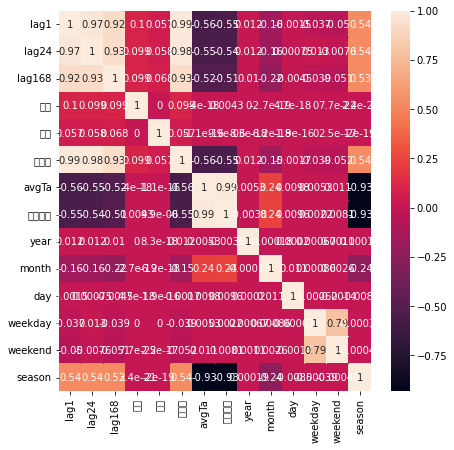

In [ ]:
# (9) feature selection

# corr
plt.figure(figsize=(7,7))
display(sns.heatmap(train.corr(), annot=True))

# reg
import pandas as pd
import statsmodels.api as sm

def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

model_forward = forward_regression(train_X, train_y, threshold_in=0.05)
model_backward = backward_regression(train_X, train_y, threshold_out=0.05)
print('전진선택법:', model_forward)
print('후진제거법:', model_backward)

In [ ]:
### 모델링
features = ['lag1', 'lag24', '시간', '구분', 'avgTa', '예상기온', 'month', 'weekend', 'year', 'day']
print('모델 features:', features)
train_X = train_X[features]
test_X = test_X[features]
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=42)

# (1) model selection
lr = LinearRegression()
enet = ElasticNet(random_state=42)
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
ext = ExtraTreesRegressor(random_state=42)
ada = AdaBoostRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)
cat = CatBoostRegressor(silent=True, random_state=42)

models = [lr, enet, dt, rf, ext, ada, gbr, xgb, lgbm, cat]
for model in models:
    name = model.__class__.__name__
    scores = cross_val_score(model, X=X_train, y=y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    mae = (-1)*np.mean(scores) 
    print('Model %s - RMAE: %.4f' % (name, np.sqrt(mae))) 

모델 features: ['lag1', 'lag24', '시간', '구분', 'avgTa', '예상기온', 'month', 'weekend', 'year', 'day']
Model LinearRegression - RMAE: 7.9872
Model ElasticNet - RMAE: 12.9769
Model DecisionTreeRegressor - RMAE: 5.4743
Model RandomForestRegressor - RMAE: 4.6243
Model ExtraTreesRegressor - RMAE: 4.7009
Model AdaBoostRegressor - RMAE: 15.4815
Model GradientBoostingRegressor - RMAE: 6.5666
Model XGBRegressor - RMAE: 6.5716
Model LGBMRegressor - RMAE: 5.3214
Model CatBoostRegressor - RMAE: 4.6102


* ['lag1', 'lag24', 'lag168', '시간', '구분', 'avgTa', '예상기온', 'year', 'month', 'day', 'weekday', 'weekend', 'season']: RF - 4.6889
* ['lag1', 'lag24', '시간', '구분', 'avgTa', '예상기온', 'month', 'weekend']: RF - 4.6061
* ['lag1', 'lag24', '시간', '구분', '예상기온', 'month', 'day', 'weekday']: RF - 4.6346
* __['lag1', 'lag24', '시간', '구분', 'avgTa', '예상기온', 'month', 'weekend', 'year', 'day']: Cat - 4.6102__

In [ ]:
# (2) tuning
#print(help(RandomForestRegressor))
# params = {
#          'n_estimators': [10, 50, 100],
#          'max_depth': [3, 5, 7],
#          'min_samples_split': [2, 3, 4],
#          'min_samples_leaf': [3, 4, 5],
# }
# grid = GridSearchCV(rf, param_grid=params, cv=5, scoring='neg_mean_absolute_error')
# grid.fit(X_train, y_train)
# print((-1)*grid.best_score_, grid.best_params_)

# (3) final
#final = RandomForestRegressor(**grid.best_params_)
final = CatBoostRegressor(silent=True, n_estimators=100, max_depth=9, random_state=42)
final.fit(X_train, y_train)
final_pred = final.predict(X_test)
print(mean_absolute_error(final_pred, y_test)) 

22.643436630298517


* ['lag1', 'lag24', 'lag168', '시간', '구분', 'avgTa', '예상기온', 'year', 'month', 'day', 'weekday', 'weekend', 'season']: 42.28255143274745
* ['lag1', 'lag24', '시간', '구분', 'avgTa', '예상기온', 'month', 'weekend']: 42.33024489492275
* __['lag1', 'lag24', '시간', '구분', 'avgTa', '예상기온', 'month', 'weekend', 'year', 'day']: 22.643436630298517__ -> 제출 0.496900066 과적합인듯

In [ ]:
### 제출 
preds = final.predict(test_X)
sub['공급량'] = preds
sub.to_csv('jk_1202_cat.csv', index=False)
#sub.to_csv('jk_1201_lag2.csv', index=False)
#sub.to_csv('jk_1201_lag3.csv', index=False)

### 211205
* 날씨 데이터 변경 및 공급량 이상치 제거
* CatBoost

In [ ]:
### 1. 준비

# (1) 라이브러리
!pip install catboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# (2) 데이터
PATH = '/content/drive/MyDrive/DACON/'
train = pd.read_csv(PATH+'한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
#train = pd.read_csv('/content/drive/Shareddrives/Kaggle_정예멤버/가스예측/5_City_weather.csv').drop('Unnamed: 0', axis=1) # 5 city weather 추가
test = pd.read_csv(PATH+'test.csv')
sub = pd.read_csv(PATH+'sample_submission.csv')

In [ ]:
### 2. 전처리

# (1) outlier
for i in train['구분'].unique():
  globals()['train_{}'.format(i)] = train[train['구분']==i]

# A -> 1개 
#plt.plot(train_A['연월일'], train_A['공급량'])
A_idx = train_A[train_A['공급량']>5000].index 
train_A.loc[A_idx, '공급량'] = np.nan
train_A = train_A.fillna(method='bfill')
#plt.plot(train_A['연월일'], train_A['공급량'])
# B -> 애매
#plt.plot(train_B['연월일'], train_B['공급량'])
# C -> 문제
#plt.plot(train_C['연월일'], train_C['공급량'])
# D -> 0개
#plt.plot(train_D['연월일'], train_D['공급량'])
# E -> 0개
#plt.plot(train_E['연월일'], train_E['공급량'])
# G -> 일단 4개
#plt.plot(train_G['연월일'], train_G['공급량'])
G_idx = train_G[train_G['공급량']>7000].index
train_G.loc[G_idx, '공급량'] = np.nan
train_G = train_G.fillna(method='bfill')
# #plt.plot(train_G['연월일'], train_G['공급량'])
# # H -> 일단 5개 
# #plt.plot(train_H['연월일'], train_H['공급량'])
H_idx = train_H[train_H['공급량']>1000].index
train_H.loc[H_idx, '공급량'] = np.nan
train_H = train_H.fillna(method='bfill')
# #plt.plot(train_H['연월일'], train_H['공급량'])

train = pd.concat([train_A, train_B, train_C, train_D, train_E, train_G, train_H], axis=0).reset_index().drop('index', axis=1)  

In [ ]:
# (2) weather
weather = pd.read_csv('/content/drive/Shareddrives/Kaggle_정예멤버/가스예측/5_City_weather.csv', index_col=0)

# 5개 평균
sc = MinMaxScaler()
weather['전국'] = weather[['경기도', '충청도', '전라도', '강원도', '경상도', '제주도']].mean(axis=1)
weather['전국_scaled'] = pd.DataFrame(sc.fit_transform(weather[['전국']]), columns=['전국_scaled'])

# train
train['경기도'] = weather['경기도']
train['충청도'] = weather['충청도']
train['전라도'] = weather['전라도']
train['강원도'] = weather['강원도']
train['경상도'] = weather['경상도']
train['제주도'] = weather['제주도']
train['전국'] = weather['전국']
train['전국_scaled'] = weather['전국_scaled']

# test -> 뒤에서 월일로 묶고 진행(평균 대치)

In [ ]:
# (3) time series
train['연월일'] = pd.to_datetime(train['연월일'])
train['월일'] = train['연월일'].apply(lambda x : str(x)[5:10])
train['year'] = train['연월일'].dt.year
train['month'] = train['연월일'].dt.month
train['day'] = train['연월일'].dt.day
train['weekday'] = train['연월일'].dt.weekday

test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

test['연월일'] = pd.to_datetime(test['일자'])
test['월일'] = test['일자'].apply(lambda x : str(x)[5:10])
test['year'] = test['연월일'].dt.year
test['month'] = test['연월일'].dt.month
test['day'] = test['연월일'].dt.day
test['weekday'] = test['연월일'].dt.weekday

# (4) lag -> 추가
train['lag1'] = 0
train['lag24'] = 0
train['lag168'] = 0
for i in train['구분'].unique(): 
    train.loc[train['구분'] == i, 'lag1'] = train['공급량'].shift(1) # 한 시간 전
    train.loc[train['구분'] == i, 'lag24'] = train['공급량'].shift(24) # 하루 전
    train.loc[train['구분'] == i, 'lag168'] = train['공급량'].shift(168) # 일주일 전
train = train.fillna(method = 'bfill')

train_lag = train.groupby(['월일' , '시간' , '구분'])[['lag1' ,'lag24', 'lag168']].mean().reset_index()
test = pd.merge(test, train_lag, how='left')

test_mean = train.groupby('월일')['경기도'].mean().reset_index()
test = pd.merge(test, test_mean , how = 'left')
test_mean = train.groupby('월일')['충청도'].mean().reset_index()
test = pd.merge(test, test_mean , how = 'left')
test_mean = train.groupby('월일')['전라도'].mean().reset_index()
test = pd.merge(test, test_mean , how = 'left')
test_mean = train.groupby('월일')['강원도'].mean().reset_index()
test = pd.merge(test, test_mean , how = 'left')
test_mean = train.groupby('월일')['경상도'].mean().reset_index()
test = pd.merge(test, test_mean , how = 'left')
test_mean = train.groupby('월일')['제주도'].mean().reset_index()
test = pd.merge(test, test_mean , how = 'left')
test_mean = train.groupby('월일')['전국'].mean().reset_index()
test = pd.merge(test, test_mean , how = 'left')
test_mean = train.groupby('월일')['전국_scaled'].mean().reset_index()
test = pd.merge(test, test_mean , how = 'left')

# (5) weekend 
train['weekend'] = train['weekday'].apply(lambda x : 1 if x in [5,6] else 0)
test['weekend'] = test['weekday'].apply(lambda x : 1 if x in [5,6] else 0)

# (6) season 
train['season'] = train['month'].apply(lambda x : 3 if x in [1,2,12] else (2 if x in [3,11] else ( 1 if x in [4,5,10] else 0)))
test['season'] = test['month'].apply(lambda x : 3 if x in [1,2,12] else (2 if x in [3,11] else ( 1 if x in [4,5,10] else 0)))

# (7) scaling 
X_n = train[['lag1', 'lag24', 'lag168']]
X_c = train.drop(['lag1', 'lag24', 'lag168'], axis=1)
test_n = test[['lag1', 'lag24', 'lag168']]
test_c = test.drop(['lag1', 'lag24', 'lag168'], axis=1)

sc = MinMaxScaler()
X_n = pd.DataFrame(sc.fit_transform(X_n), columns=X_n.columns)
test_n = pd.DataFrame(sc.fit_transform(test_n), columns=test_n.columns)

# (8) encoding
en = LabelEncoder()
X_c['구분'] = en.fit_transform(X_c['구분'])
test_c['구분'] = en.fit_transform(test_c['구분'])

# (9) split
train = pd.concat([X_n ,X_c], axis=1)
test = pd.concat([test_n ,test_c], axis=1)
train_y = train['공급량']
train_X = train.drop(['연월일', '월일', '공급량'], axis=1)
test_X = test.drop(['일자|시간|구분', '일자', '연월일', '월일'], axis=1)

print('전체 features:', list(train_X.columns))

전체 features: ['lag1', 'lag24', 'lag168', '시간', '구분', '경기도', '충청도', '전라도', '강원도', '경상도', '제주도', '전국', '전국_scaled', 'year', 'month', 'day', 'weekday', 'weekend', 'season']


In [ ]:
# # (10) feature selection

# # 한글폰트 -> 왜 안됨? -- 
# # from matplotlib import font_manager, rc
# # font_path = "/content/drive/MyDrive/NanumGothic.ttf"
# # font = font_manager.FontProperties(fname=font_path).get_name()
# # rc('font', family=font)
# # rc('axes', unicode_minus=False)

# # corr
# plt.figure(figsize=(7,7))
# display(sns.heatmap(train.corr(), annot=True))

# # reg
# import pandas as pd
# import statsmodels.api as sm

# def forward_regression(X, y,
#                        threshold_in,
#                        verbose=False):
#     initial_list = []
#     included = list(initial_list)
#     while True:
#         changed=False
#         excluded = list(set(X.columns)-set(included))
#         new_pval = pd.Series(index=excluded)
#         for new_column in excluded:
#             model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
#             new_pval[new_column] = model.pvalues[new_column]
#         best_pval = new_pval.min()
#         if best_pval < threshold_in:
#             best_feature = new_pval.idxmin()
#             included.append(best_feature)
#             changed=True
#             if verbose:
#                 print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

#         if not changed:
#             break

#     return included

# def backward_regression(X, y,
#                            threshold_out,
#                            verbose=False):
#     included=list(X.columns)
#     while True:
#         changed=False
#         model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
#         # use all coefs except intercept
#         pvalues = model.pvalues.iloc[1:]
#         worst_pval = pvalues.max() # null if pvalues is empty
#         if worst_pval > threshold_out:
#             changed=True
#             worst_feature = pvalues.idxmax()
#             included.remove(worst_feature)
#             if verbose:
#                 print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
#         if not changed:
#             break
#     return included

# model_forward = forward_regression(train_X, train_y, threshold_in=0.05)
# model_backward = backward_regression(train_X, train_y, threshold_out=0.05)
# print('전진선택법:', model_forward)
# print('후진제거법:', model_backward)

In [ ]:
### 모델링
features = ['lag1', 'lag24', 'lag168', '시간', '구분', '경기도', '충청도', '전라도', '강원도', '경상도', '제주도', '전국', '전국_scaled', 'year', 'month', 'day', 'weekday', 'weekend', 'season']
#print('모델 features:', features)
train_X = train_X[features]
test_X = test_X[features]
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42)

# # (1) model selection
# lr = LinearRegression()
# enet = ElasticNet(random_state=42)
# dt = DecisionTreeRegressor(random_state=42)
# rf = RandomForestRegressor(random_state=42)
# ext = ExtraTreesRegressor(random_state=42)
# ada = AdaBoostRegressor(random_state=42)
# gbr = GradientBoostingRegressor(random_state=42)
# xgb = XGBRegressor(random_state=42)
# lgbm = LGBMRegressor(random_state=42)
# cat = CatBoostRegressor(silent=True, random_state=42)

# models = [lr, enet, dt, rf, ext, ada, gbr, xgb, lgbm, cat]
# for model in models:
#     name = model.__class__.__name__
#     scores = cross_val_score(model, X=X_train, y=y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
#     mae = (-1)*np.mean(scores) 
#     print('Model %s - RMAE: %.4f' % (name, np.sqrt(mae))) 

# (2) tuning
#print(help(RandomForestRegressor))
# params = {
#          'n_estimators': [10, 50, 100],
#          'max_depth': [3, 5, 7],
#          'min_samples_split': [2, 3, 4],
#          'min_samples_leaf': [3, 4, 5],
# }
# grid = GridSearchCV(rf, param_grid=params, cv=5, scoring='neg_mean_absolute_error')
# grid.fit(X_train, y_train)
# print((-1)*grid.best_score_, grid.best_params_)

# (3) final
#final = RandomForestRegressor(**grid.best_params_)
#final = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
final = CatBoostRegressor(silent=True, n_estimators=300, max_depth=9, random_state=42)
final.fit(X_train, y_train)
final_pred = final.predict(X_test)
print(mean_absolute_error(final_pred, y_test)) 

29.690725581430083


In [ ]:
# (4) score
# def nmae(true_df, pred_df):
#     target_idx = true_df.iloc[:,0]
#     pred_df = pred_df[pred_df.iloc[:,0].isin(target_idx)]
#     pred_df = pred_df.sort_values(by=[pred_df.columns[0]], ascending=[True])
#     true_df = true_df.sort_values(by=[true_df.columns[0]], ascending=[True])
#     true = true_df.iloc[:,0].to_numpy()
#     pred = pred_df.iloc[:,0].to_numpy()
#     score = np.mean((np.abs(true-pred))/true)
#     return score

df_true = pd.DataFrame(y_test).reset_index().drop('index', axis=1)
df_pred = pd.DataFrame(final_pred, columns=['pred'])
true = df_true.iloc[:,0].to_numpy()
pred = df_pred.iloc[:,0].to_numpy()
score = np.mean((np.abs(true-pred))/true)
print(score)

0.0984162789537347


In [ ]:
### 4. 제출 
preds = final.predict(test_X)
sub['공급량'] = preds
sub.to_csv('jk_1206_cat.csv', index=False)
sub

,일자|시간|구분,공급량
0,2019-01-01 01 A,2632.420034
1,2019-01-01 02 A,2303.995106
2,2019-01-01 03 A,2291.900158
3,2019-01-01 04 A,2339.489216
4,2019-01-01 05 A,2483.871576
...,...,...
15115,2019-03-31 20 H,295.392299
15116,2019-03-31 21 H,288.264716
15117,2019-03-31 22 H,320.836853
15118,2019-03-31 23 H,245.685243


* __제출파일 - MAE - NMAE - SCORE__
* jk_1206_cat - 19.8640 - 0.0591 - 0.349363597

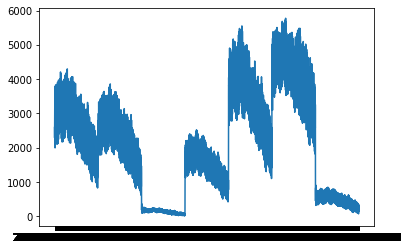

In [ ]:
plt.plot(sub['일자|시간|구분'], sub['공급량'])